## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import sklearn
# %matplotlib qt

## Variables to set

In [2]:
DATASET = "32FINAL_NORM.csv"
DATAPATH = path.join("..", "capture", "processed", DATASET)
SAMPLES_TO_VIEW = [2,240,500,780]
NORMALIZE_DATASET = False

## Load dataset

In [3]:
dataset = pd.read_csv(DATAPATH)
# dataset
unique, counts = np.unique(dataset['Class'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 250, 1: 250, 2: 75, 3: 250, 4: 25, 5: 250}


## Normalize dataset to eliminate negative values

In [4]:
if NORMALIZE_DATASET:
    # Drop class column and headers
    dataset_array = dataset.iloc[:,:-1].to_numpy()
    dataset_classes = np.expand_dims(dataset.iloc[:,-1].to_numpy(), axis=1)
    dataset_columns = list(dataset.columns)

    ds_min = dataset_array.min()
    ds_max = dataset_array.max()
    print("Current minimum: {}, Current maximum: {}".format(ds_min, ds_max))

    new_min = 0
    new_max = ds_max + ((-1)*ds_min) # new max = max + min, 
    # i.e. it is a translation of scale from range -x to +y to range 0 to +y'
    print("New minimum: {}, New maximum: {}".format(new_min, new_max))

    new_array = np.zeros((dataset_array.shape[0], dataset_array.shape[1]))

    # Normalization
    new_array = (((dataset_array - ds_min) / (ds_max - ds_min)) * new_max).astype("int64")

    new_array = np.concatenate((new_array, dataset_classes), axis=1)

    # Convert to DataFrame again
    dataset = pd.DataFrame(new_array, columns=dataset_columns, index=None)
    # dataset
    dataset.to_csv(path.join("..","results","extraction","32FINAL_NORM.csv"), sep=",", index=False)

In [5]:
X = [i for i in range(100)]
print(X)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


## Generate a figure with plots of the initial samples

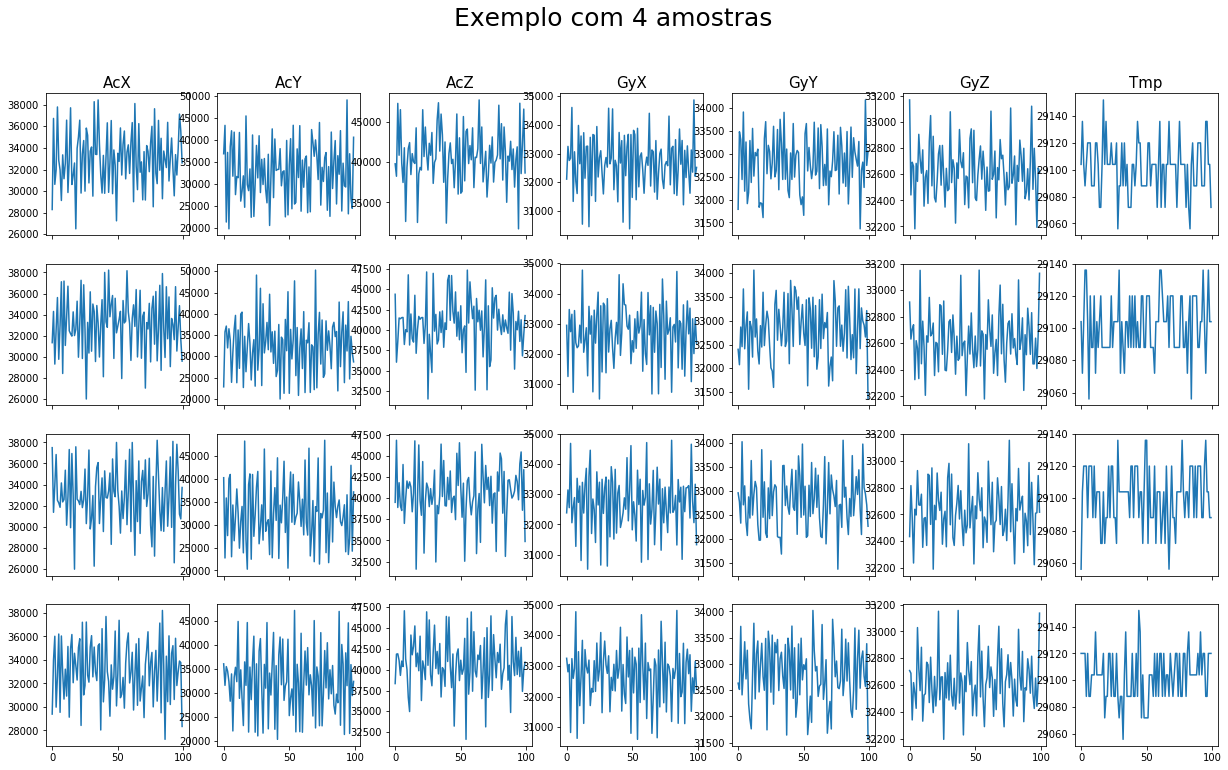

In [6]:
fig, axs = plt.subplots(len(SAMPLES_TO_VIEW), 7, sharex='col', figsize=(21,len(SAMPLES_TO_VIEW)*3))
for i in range(len(SAMPLES_TO_VIEW)):
    for j in range(7):
        y = dataset.iloc[i,j*100:(j+1)*100]
        axs[i,j].plot(X, y)
        if i == 0:
            axs[i,j].set_title(dataset.columns[j*100][:-1], fontsize=15)

fig.suptitle("Exemplo com "+str(len(SAMPLES_TO_VIEW))+" amostras", fontsize=25)            
# plt.show()
fig.savefig(path.join("..","results","extraction","plot",DATASET[:-4]+".PNG"), dpi=300)

# Feature Extraction
## Import extraction libraries
Using code from Navar M. M. Nascimento -> https://github.com/navarmn/feature_extraction_signal for Fourier and HOS extraction.
Using code from Geraldo Luís Bezerra Ramalho -> Private's Google Colaboratory for extraction using Structural Cooccurrence Matrix - SCM method.

In [7]:
from src.feature_extraction import Fourier, HOS
from src.SCM import SCM

In [8]:
fe_fourier25 = Fourier(fundamental=25.0, fs=100.0, harmonics=(1, 10, 20, 30))
fe_fourier30 = Fourier(fundamental=30.0, fs=100.0, harmonics=(1, 10, 20, 30))
fe_fourier35 = Fourier(fundamental=35.0, fs=100.0, harmonics=(1, 10, 20, 30))
fe_HOS = HOS()
fe_SCM = SCM(f=np.array([0]), g=np.array([0]), minmax=[0,0], NL=8, d=[0, 0], verbose=False)

Our dataset is composed by 1100 sensor captures (dataset rows). Each one has 100 samples per measures (AcX, AcY, AcZ, GyX, GyY, GyZ, Tmp). The Tmp values will be despized for this work. So, we need to extract each measure's vector and generate a new dataset with features.

In [9]:
# excluding Tmp columns
tmp_head = []
for i in range(100):
    tmp = "Tmp"+str(i)
    tmp_head.append(tmp)
if "Tmp0" in dataset.columns:
    dataset = dataset.drop(columns=tmp_head)
tmp_head.clear()
# dataset

import time

current_milli_time = lambda: int(round(time.time() * 1000))

## Fourier extraction
Fourier's extractor receive as parameters: fundamental frequency, sampling frequency and harmonics (multiples) of the input signal. Each class needs to be extracted for different configurations of the object, since classes differ themselves by fundamental frequency.

Each measure (AcX, AcY, AcZ, GyX, GyY and GyZ) are extracted separated, since they are different signals, with 100 values. After extraction, will be 4 attributes for each measure, resulting in a dataset with 1100 rows and 25 columns ((4 attributes X 6 measures) + Class).

In [10]:
def fourier_extraction(dataset, extractors, measures):
    print('Fourier: ')
    time_list = []
    
    out_data_list = []
    out_row_list = []

    for row in range(len(dataset.index)):
        dataset_row = dataset.iloc[row,:]
        class_num = dataset_row['Class']
        dataset_fourier = dataset_row.values[:-1]
        dataset_fourier = pd.DataFrame(np.reshape(dataset_fourier, (100,6), order='F'), columns=measures)
        out_row_list.clear()
        
        extract_start = current_milli_time()
        for measure in measures:
            out_fourier = extractors[class_num].transform(dataset_fourier[measure])
            out_row_list.append(out_fourier['features'])
        extract_time = current_milli_time() - extract_start
        time_list.append(extract_time)
        
        out_row_list.append([class_num])
        row_list = [item for sublist in out_row_list for item in sublist]
        out_data_list.append(row_list)

    out_head = []
    for measure in measures:
        for i in range(4):
            column = measure+str(i)
            out_head.append(column)
    out_head.append("Class")

    out_data_list = np.asarray(out_data_list)
    out_dataframe = pd.DataFrame(out_data_list, columns=out_head, index=None)
    out_dataframe = out_dataframe.astype({"Class": int})
    
    print("Amostras: ", len(time_list))
    time_mean = np.mean(time_list)
    print("Extraction time mean :", time_mean)
    time_std = np.std(time_list)
    print("Extraction time std: ", time_std)
    
    return out_dataframe

## HOS extraction
Higher-Order Statistics extractor do not receive parameters. All classes will be extracted in the same way. The resulting feature vector corresponds to four statistics of the input signal: rms, variance, skewness and the kurtosis.

Each measure (AcX, AcY, AcZ, GyX, GyY and GyZ) are extracted separated, since they are different signals, with 100 values. After extraction, will be 4 attributes for each measure, resulting in a dataset with 1100 rows and 25 columns ((4 attributes X 6 measures) + Class).

In [11]:
def HOS_extraction(dataset, extractor, measures):
    print('HOS: ')
    time_list = []    
    
    out_data_list = []
    out_row_list = []

    for row in range(len(dataset.index)):
        dataset_row = dataset.iloc[row,:]
        class_num = dataset_row['Class']
        dataset_HOS = dataset_row.values[:-1]
        dataset_HOS = pd.DataFrame(np.reshape(dataset_HOS, (100,6), order='F'), columns=measures)
        out_row_list.clear()
        
        extract_start = current_milli_time()
        for measure in measures:
            out_HOS = extractor.transform(dataset_HOS[measure])
            out_row_list.append(out_HOS['features'])
        extract_time = current_milli_time() - extract_start
        time_list.append(extract_time)
        
        out_row_list.append([class_num])
        row_list = [item for sublist in out_row_list for item in sublist]
        out_data_list.append(row_list)

    out_head = []
    for measure in measures:
        for i in range(4):
            column = measure+str(i)
            out_head.append(column)
    out_head.append("Class")

    out_data_list = np.asarray(out_data_list)
    out_dataframe = pd.DataFrame(out_data_list, columns=out_head, index=None)
    out_dataframe = out_dataframe.astype({"Class": int})
    
    print("Amostras: ", len(time_list))
    time_mean = np.mean(time_list)
    print("Extraction time mean :", time_mean)
    time_std = np.std(time_list)
    print("Extraction time std: ", time_std)
    
    return out_dataframe

## SCM extraction
Structural Cooccurrence Matrix is a analysis method that can be used as an extractor. All classes will be extracted in the same way. The resulting feature vector corresponds to eight features of the input signal, calculated from a matrix resulting of comparison between raw signal and the same signal, after a low-pass filter: COR, IDM, ENT, CSD, CSR, MDR, DKL and CAD.

Each measure (AcX, AcY, AcZ, GyX, GyY and GyZ) are extracted separated, since they are different signals, with 100 values. After extraction, will be 8 attributes for each measure, resulting in a dataset with 1100 rows and 49 columns ((8 attributes X 6 measures) + Class).

In [12]:
def SCM_extraction(dataset, extractor, signal_filter, measures):    
    print('SCM: ')
    time_list = []   
    
    out_data_list = []
    out_row_list = []
    
    for row in range(len(dataset.index)):
        dataset_row = dataset.iloc[row,:]
        class_num = dataset_row['Class']
        dataset_SCM = dataset_row.values[:-1]
        dataset_SCM = pd.DataFrame(np.reshape(dataset_SCM, (100,6), order='F'), columns=measures)
        out_row_list.clear()
        
        extract_start = current_milli_time()
        for measure in measures:
            signal_f = dataset_SCM[measure].to_numpy(dtype="int64")
            signal_g = dataset_SCM[measure].to_numpy(dtype="int64")
            signal_f = np.expand_dims(signal_f, axis=1)
            signal_g = np.expand_dims(signal_g, axis=1)
            signal_f = signal_f.T
            signal_g = signal_g.T
            extractor = SCM(f=signal_f, g=signal_g, minmax=[0,0], NL=8, d=[0, 0], verbose=False)
            extractor.function_k = signal_filter
            extractor.d = np.array([[0, 0]])
            extractor.compute_matrix()
            extractor.compute_attributes()
            out_row_list.append(extractor.attributes.values())
        extract_time = current_milli_time() - extract_start
        time_list.append(extract_time)    
        
        out_row_list.append([class_num])
        row_list = [item for sublist in out_row_list for item in sublist]
        out_data_list.append(row_list)

    out_head = []
    for measure in measures:
        for i in range(8):
            column = measure+str(i)
            out_head.append(column)
    out_head.append("Class")

    out_data_list = np.asarray(out_data_list)
    out_dataframe = pd.DataFrame(out_data_list, columns=out_head, index=None)
    out_dataframe = out_dataframe.astype({"Class": int})
    
    print("Amostras: ", len(time_list))
    time_mean = np.mean(time_list)
    print("Extraction time mean :", time_mean)
    time_std = np.std(time_list)
    print("Extraction time std: ", time_std)
    
    return out_dataframe

## Extraction general

After call all functions and generate dataframes with corresponding features, CSV's of each dataframe would be saved in destiny folder.

In [13]:
import scipy.ndimage

measures = ["AcX", "AcY", "AcZ", "GyX", "GyY", "GyZ"]
fourier_extractors = [fe_fourier25, fe_fourier25, fe_fourier25, fe_fourier30, fe_fourier30, fe_fourier35] # class 0 to 5

# user-defined k (low-pass average filter)
def SCM_filter(s):
  kernel = np.ones((3,3))
  ret = scipy.ndimage.filters.convolve(s.astype(float), kernel, mode="reflect")/kernel.sum()
  return np.around(ret).astype(s.dtype)

# Extraction functions
fourier_dataframe = fourier_extraction(dataset, fourier_extractors, measures)
HOS_dataframe = HOS_extraction(dataset, fe_HOS, measures)
SCM_dataframe = SCM_extraction(dataset, fe_SCM, SCM_filter, measures)

# Save CSV's
fourier_dataframe.to_csv(path.join("..","results","extraction", DATASET[:-4]+"_Fourier.csv"), sep=",", index=False)
HOS_dataframe.to_csv(path.join("..","results","extraction", DATASET[:-4]+"_HOS.csv"), sep=",", index=False)
SCM_dataframe.to_csv(path.join("..","results","extraction", DATASET[:-4]+"_SCM.csv"), sep=",", index=False)

Fourier: 
Amostras:  1100
Extraction time mean : 1.8827272727272728
Extraction time std:  0.7803681055535838
HOS: 
Amostras:  1100
Extraction time mean : 11.49909090909091
Extraction time std:  0.6037753125949864
SCM: 
Amostras:  1100
Extraction time mean : 4.755454545454546
Extraction time std:  0.5001974816621502


# Features plotting

Now, the features will be displayed, and the plot will be saved. That plot consists in a scatter matrix plot, which show a dispersion of elements, comparing pairs of features of a selected measure.

In [20]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_features(data_name, dataframe, classes, features, features_name, extractor_name):
    plt.rcParams["figure.subplot.right"] = .8

    fig = pd.plotting.scatter_matrix(dataframe[[f for f in features]], figsize=(24,13), 
                                     c=dataframe["Class"], label=classes, s=400, alpha=.8, 
                                     cmap=discrete_cmap(5, 'rainbow'))



    handles = [plt.plot([], [], color=discrete_cmap(5, 'rainbow')(i), ls="", marker=".", 
                        markersize=np.sqrt(50))[0] for i in range(5)]

    plt.legend(handles, classes, loc=(1.02,0))
    plt.suptitle(data_name + " - " + features_name + " - " + extractor_name, fontsize=24)
    plt.savefig(path.join("..","results","extraction","plot",data_name+"_"+features_name+"_"+extractor_name+".png"), 
                dpi=300)
    plt.clf()

## Plotting general

In [15]:
list_drops = [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263, 264, 265, 267, 268, 269, 270, 271, 272, 274, 275, 276, 278, 279, 280, 281, 282, 283, 285, 286, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 311, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 377, 378, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 402, 403, 404, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 421, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 437, 439, 440, 441, 442, 443, 445, 446, 447, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 493, 494, 495, 496, 497, 498, 499, 500, 502, 503, 504, 505, 506, 508, 510, 511, 513, 514, 516, 517, 518, 519, 520, 522, 524, 525, 526, 527, 531, 532, 534, 537, 538, 539, 541, 542, 543, 544, 545, 547, 550, 551, 552, 555, 556, 557, 558, 559, 561, 563, 564, 567, 568, 569, 571, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 613, 614, 615, 616, 617, 618, 620, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 663, 664, 665, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 679, 680, 681, 682, 683, 685, 686, 689, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 710, 711, 712, 713, 714, 715, 716, 717, 719, 721, 722, 723, 724, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 740, 741, 742, 743, 745, 746, 747, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 786, 788, 789, 790, 791, 792, 793, 794, 795, 796, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 850, 851, 852, 853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 867, 869, 870, 871, 872, 873, 874, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 909, 912, 913, 914, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 970, 971, 972, 975, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1061, 1062, 1063, 1064, 1065, 1067, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1085, 1086, 1087, 1088, 1090, 1091, 1092, 1093, 1095, 1096, 1097, 1098, 1099]

In [16]:
datasets_list = [fourier_dataframe, HOS_dataframe, SCM_dataframe]
classes = [0, 2, 3, 4, 5]
changeClass_dict = {0:0, 2:1, 3:2, 4:3, 5:4}

def join_classes(df, dict_groups):
    df['Class'].replace(dict_groups, inplace=True)
    return df

# Exclude classes that are not in scope 
for ds in datasets_list:
    ds.drop(list_drops, inplace=True)
    for i in range(6):
        if i not in classes:
            indexNames = ds[ds['Class'] == i].index
            ds.drop(indexNames, inplace=True) # Delete these row indexes from dataframe
                       
for ds in datasets_list:
    ds = join_classes(ds, changeClass_dict)
    
print("Experiment Classes: ", classes)
classes = np.unique(list(changeClass_dict.values())).tolist()
print("New Classes: ", classes)

Experiment Classes:  [0, 2, 3, 4, 5]
New Classes:  [0, 1, 2, 3, 4]


In [18]:
for ds in datasets_list:
    unique, counts = np.unique(ds['Class'], return_counts=True)
    print(dict(zip(unique, counts)))

{0: 25, 1: 25, 2: 25, 3: 25, 4: 25}
{0: 25, 1: 25, 2: 25, 3: 25, 4: 25}
{0: 25, 1: 25, 2: 25, 3: 25, 4: 25}


In [26]:
labels = ["25 NORMAL", "25 VAZIO", "30 NORMAL", "30 VAZIO", "35 NORMAL"]
features_name = "GyZ"

features = []
for i in range(4):
    feature = features_name+str(i)
    features.append(feature)

SCM_features = []
for j in range(8):
    feature = features_name+str(j)
    SCM_features.append(feature)

plot_features(DATASET[:-4], datasets_list[0], labels, features, features_name, "Fourier")
plot_features(DATASET[:-4], datasets_list[1], labels, features, features_name, "HOS")
plot_features(DATASET[:-4], datasets_list[2], labels, SCM_features, features_name, "SCM")

features.clear()
SCM_features.clear()

<Figure size 1728x936 with 0 Axes>

<Figure size 1728x936 with 0 Axes>

<Figure size 1728x936 with 0 Axes>